In [27]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
from tqdm.notebook import tqdm

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

from jaxley_mech.synapses.ribbon import RibbonSynapse
from jaxley_mech.channels.kwu09 import Kv, Hyper, Ca, ClCa, KCa, Leak, CaPump, CaNernstReversal
from jaxley_mech.channels.chen24 import Phototransduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Deterministic Ribbon Synapse Model

In [28]:
n_cells = 2
dt = 0.05
t_max = 300
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0),
    network.cell(1).branch(0).comp(0),
    RibbonSynapse(solver='diffrax_implicit'),
)
cell1 = network.cell([0])
cell2 = network.cell([1])

# Set some parameters
network.RibbonSynapse.set("RibbonSynapse_gS", 1e-05)
network.set("v", -35.0)

# Insert mechanisms
cell1.insert(Kv())
cell1.insert(Hyper())
cell1.insert(Ca())
cell1.insert(ClCa())
cell1.insert(KCa())
cell1.insert(Leak())
cell1.insert(CaPump())
cell1.insert(CaNernstReversal())
cell1.insert(Phototransduction())
cell2.insert(Leak())

network.init_states()

network.delete_recordings()
network.cell(0).record(verbose=False)
network.cell(1).record(verbose=False)
network.cell(0).record("RibbonSynapse_exo", verbose=False)
network.cell(0).record("RibbonSynapse_RRP", verbose=False)
network.cell(0).record("RibbonSynapse_IP", verbose=False)
network.cell(0).record("RibbonSynapse_RP", verbose=False)

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[int(100/dt):int(120/dt)].set(50_000)

data_clamps = None
data_clamps = network.cell(0).data_clamp("Phototransduction_Stim", inp_current, data_clamps=data_clamps)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
)

fig, ax = plt.subplots(6, 1, figsize=(5, 8), sharex=True)

_ = ax[0].plot(time, inp_current)
_ = ax[1].plot(time, v[0, :-1], label="Cell 0")
_ = ax[1].plot(time, v[1, :-1], label="Cell 1")
ax[1].legend(frameon=False)
_ = ax[2].plot(time, v[2, :-1], label="Glu/Exocytozed", color="purple")
_ = ax[3].plot(time, v[3, :-1], label="RRP", color="blue")
_ = ax[4].plot(time, v[4, :-1], label="IP", color="green")
_ = ax[5].plot(time, v[5, :-1], label="RP", color="red")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[2].set_ylabel("Glucose/Exocytosed")
ax[3].set_ylabel("RRP")
ax[4].set_ylabel("IP")
ax[5].set_ylabel("RP")
ax[5].set_xlabel("Time (ms)")
sns.despine()
plt.tight_layout();

TypeError: cannot unpack non-iterable float object

#### Changing the slope of the calcium nonlinearity

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

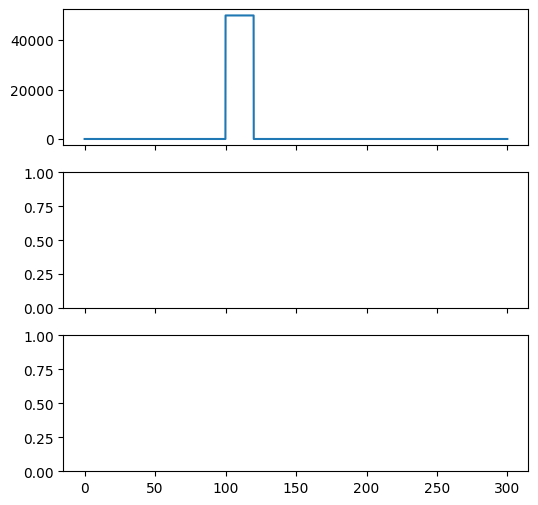

In [ ]:
ks = [0, 0.25, 0.5, 1, 5, 10]
V_halves = [-40, -35, -30, -25, -20]
k_colors = plt.cm.viridis(np.linspace(0.1, 1, len(ks)))
V_colors = plt.cm.viridis(np.linspace(0.1, 1, len(V_halves)))

fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

# reset other changing params to their defaults
network.RibbonSynapse.set("RibbonSynapse_V_half", -35.0)
network.RibbonSynapse.set("RibbonSynapse_e_max", 1.0)
network.RibbonSynapse.set("RibbonSynapse_r_max", 2.0)
network.RibbonSynapse.set("RibbonSynapse_i_max", 4.0)

for i, k in enumerate(tqdm(ks)):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_k", k)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=k_colors[i], label=fr"k = {k}")

# Reset k to the default
network.RibbonSynapse.set("RibbonSynapse_k", 1.0)

for i, v0 in enumerate(tqdm(V_halves)):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_V_half", v0)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
    )

    _ = ax[2].plot(time, v[0, :-1], color="k")
    _ = ax[2].plot(time, v[1, :-1], color=V_colors[i], label=f"$v_0$ = {v0}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax[2].set_ylabel("Voltage (mV)")
ax[2].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax[2].set_xlabel("Time (ms)")
sns.despine()
plt.tight_layout()
plt.show()

#### Changing the rates of vesicle movement

  0%|          | 0/4 [00:00<?, ?it/s]

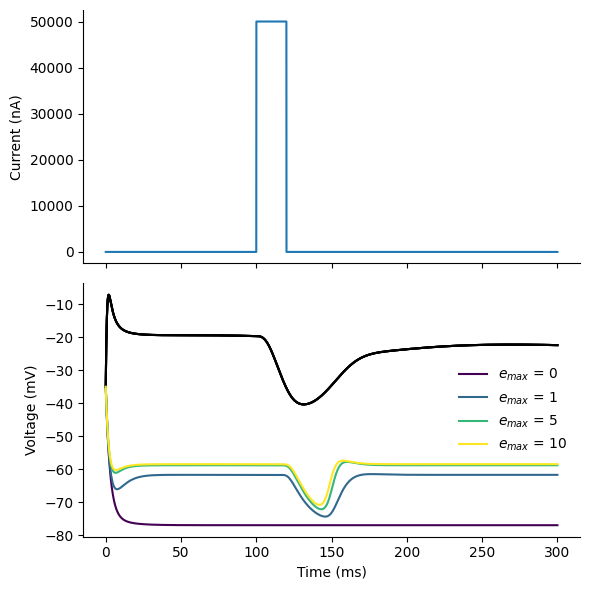

In [ ]:
e_maxes = [0, 1, 5, 10]
colors = plt.cm.viridis(np.linspace(0, 1, len(e_maxes)))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

# reset other changing params to their defaults
network.RibbonSynapse.set("RibbonSynapse_V_half", -35.0)
network.RibbonSynapse.set("RibbonSynapse_r_max", 2.0)
network.RibbonSynapse.set("RibbonSynapse_i_max", 4.0)

for i, r in enumerate(tqdm(e_maxes)):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_e_max", r)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=colors[i], label=fr"$e_{{max}}$ = {r}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

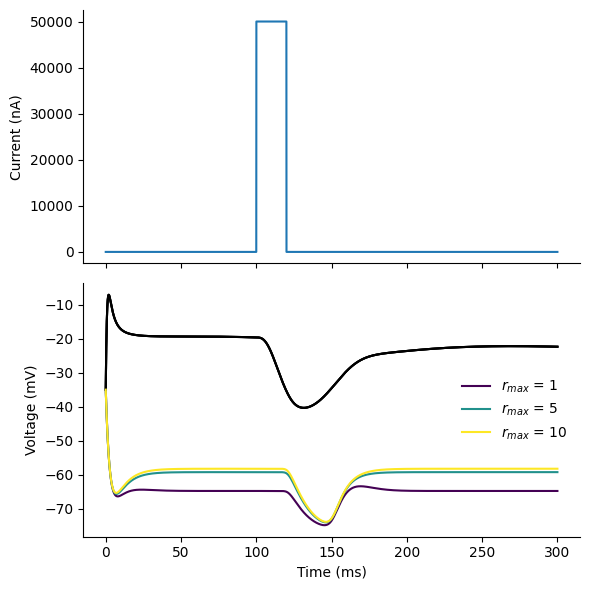

In [ ]:
r_maxes = [1, 5, 10]
colors = plt.cm.viridis(np.linspace(0, 1, len(r_maxes)))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

# reset other changing params to their defaults
network.RibbonSynapse.set("RibbonSynapse_e_max", 1.0)
network.RibbonSynapse.set("RibbonSynapse_i_max", 4.0)

for i, r in enumerate(tqdm(r_maxes)):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_r_max", r)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=colors[i], label=fr"$r_{{max}}$ = {r}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

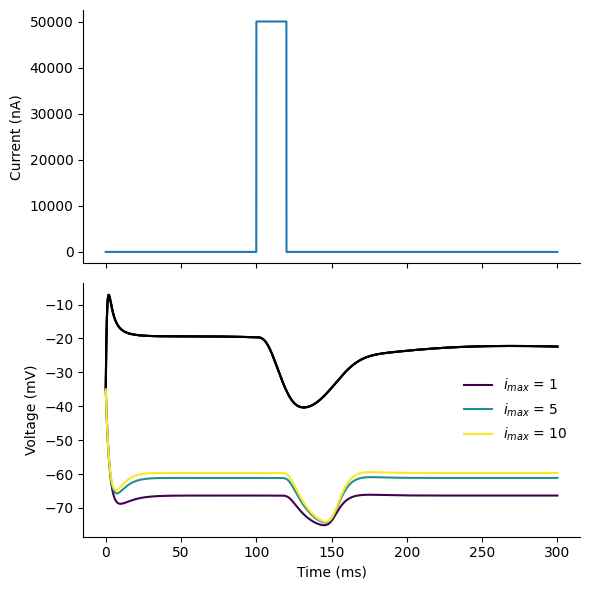

In [ ]:
i_maxes = [1, 5, 10]
colors = plt.cm.viridis(np.linspace(0, 1, len(i_maxes)))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

network.RibbonSynapse.set("RibbonSynapse_e_max", 1.0)
network.RibbonSynapse.set("RibbonSynapse_r_max", 2.0)

for i, r in enumerate(tqdm(i_maxes)):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_i_max", r)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_clamps=data_clamps
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=colors[i], label=fr"$i_{{max}}$ = {r}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-08-23 15:54:39CEST

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

jaxley_mech: 0.0.1

jaxley    : 0.0.0
jax       : 0.4.31
matplotlib: 3.7.1
seaborn   : 0.12.2
numpy     : 1.26.4

Watermark: 2.4.3

